## download OSM files


#### -> run commands in this cell from shell, not from notebook

cd /home/op/network_manila

#rm -rf data_osm_raw/

mkdir data_osm_raw

cd data_osm_raw

curl -O "http://download.geofabrik.de/asia/philippines-latest.osm.pbf"

cd ..

## import road data



In [2]:
import geopandas as gpd
import pandas as pd
import os, sys
import GOSTnets as gn
import importlib
from osgeo import ogr

In [3]:
cd /home/op/network_manila

/home/op/network_manila


In [ ]:
file = r'data_osm_raw/philippines-latest.osm.pbf' 
philippines = gn.OSM_to_network(file)

In [ ]:
#specify roads we want to keep and drop all others
accepted_road_types = ['residential', 'unclassified', 'track','service','tertiary',
                       'road','secondary','primary','trunk','primary_link','trunk_link',
                       'tertiary_link','secondary_link']
philippines.filterRoads(acceptedRoads = accepted_road_types)
philippines.roads_raw.infra_type.value_counts()

In [ ]:
#get administrative boundary of metro manila
philippines_adm2 = gpd.read_file("boundaries/philippines_adm2.geojson")
philippines_adm2 = philippines_adm2.to_crs({'init':'epsg:4326'})
manila = philippines_adm2[philippines_adm2.ADM2_NAME=="Metropolitan Manila"]
manila_geom = manila.geometry.unary_union
manila.plot()

In [ ]:
#keep only roads within the metro manila area
philippines.roads_raw = philippines.roads_raw.loc[
    philippines.roads_raw.geometry.intersects(manila_geom) == True]

In [ ]:
#generate road network geodataframe and graph objects
philippines.generateRoadsGDF(verbose = False)
philippines.initialReadIn()

In [ ]:
gn.save(philippines.network,'manila_unclean','data_osm_raw')

## clean network

In [2]:
import geopandas as gpd
import os, sys, time
import pandas as pd
import GOSTnets as gn
import importlib
import networkx as nx
import osmnx as ox
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point

In [12]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [ ]:
cd /home/op/network_manila

In [5]:
G = nx.read_gpickle('data_osm_raw/manila_unclean.pickle')

In [6]:
G

In [7]:
#add metadata for osmnx plotting
G.graph.update( {'crs' : crs_global} )
G.graph.update( {'name' : 'manila'} )
G.graph

{'crs': {'init': 'epsg:4326'}, 'name': 'manila'}

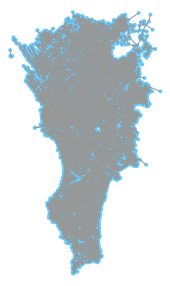

(<Figure size 201.56x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3e0a197710>)

In [10]:
ox.plot_graph(G, fig_height=5)

In [31]:
def print_changes(G,H):
    # print percentage change in number of edges and nodes between G(old graph) and H (new graph)
    
    hn = H.number_of_nodes()
    gn = G.number_of_nodes()
    he = H.number_of_edges()
    ge = G.number_of_edges()

    print("% change in # of nodes:", (hn-gn)/gn*100)
    print("% change in # of edges:", (he-ge)/ge*100)

In [42]:
def clean_network(G, crs_projected, crs_graph, thresh_combine_nodes):
    #bundles several cleanings steps into one function
    
    print("Before cleaning, graph has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")
    print("")
    print("1. Combine clusters of nodes into a single node if they are within the snapping tolerance of", 
          thresh_combine_nodes, "meters")
    H = gn.simplify_junctions(G, measure_crs = crs_projected, in_crs = crs_graph, 
                              thresh = thresh_combine_nodes)
    print_changes(G,H)
    print("")
    
    print("2. Ensure all streets are two-way by adding reflecting edges if they are missing")
    I = gn.add_missing_reflected_edges(H)
    print_changes(H,I)
    print("")
    
    print("3. Remove all nodes that are not intersections or dead-ends")
    J = gn.custom_simplify(I)
    print_changes(I, J)
    print("")
    
    # simplify the geometry type
    for u, v, data in J.edges(data = True):
        if type(data['Wkt']) == list:
                data['Wkt'] = gn.unbundle_geometry(data['Wkt'])
                
    # convert back to multidigraph
    K = gn.convert_to_MultiDiGraph(J)
    
    print("4. Remove duplicate edges, e.g. combining two lanes of the same road into one road")
    L = gn.remove_duplicate_edges(K)
    print_changes(K,L)
    print("")
    
    print("5. After removing duplicates, re-run steps 2 and 3")
    M = gn.custom_simplify(L)
    N = gn.add_missing_reflected_edges(M)
    print_changes(L, N)

    print("")
    print("After cleaning, graph has", N.number_of_nodes(), "nodes and", N.number_of_edges(), "edges")

    return N
    

In [43]:
G_clean = clean_network(G, crs_projected=crs_manila, crs_graph=crs_global, thresh_combine_nodes=5)


Before cleaning, graph has 108452 nodes and 143730 edges

1. Combine clusters of nodes into a single node if they are within the snapping tolerance of 5 meters
138067
% change in # of nodes: -5.584959244642791
% change in # of edges: -3.9400264384610035

2. Ensure all streets are two-way by adding reflecting edges if they are missing
273201
% change in # of nodes: 0.0
% change in # of edges: 97.87566905922486

3. Remove all nodes that are not intersections or dead-ends
% change in # of nodes: -12.327750378436447
% change in # of edges: -9.240815370368336

4. Remove duplicate edges, e.g. combining two lanes of the same road into one road
126277
% change in # of nodes: 0.0
% change in # of edges: -49.072613982375834

5. After removind duplicates, re-run steps 2 and 3
247696
% change in # of nodes: -0.015595063048612039
% change in # of edges: 96.1529019536416

After cleaining, graph has 89758 nodes and 247696 edges


In [44]:
gn.save(G_clean,'manila_clean','data_osm_raw')

## for development purposes: clip graph to small part of city

In [7]:
G_cleaned = nx.read_gpickle('data_osm_raw/manila_clean.pickle')

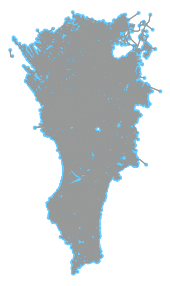

(<Figure size 201.56x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3da01fb978>)

In [47]:
#add metadata for osmnx plotting
G_cleaned.graph.update( {'crs' : crs_manila} )
G_cleaned.graph.update( {'name' : 'manila'} )
ox.plot_graph(G_cleaned, fig_height=5)

In [1]:
from shapely.geometry import box, polygon, multipolygon, Point
import shapely.geometry
from shapely.ops import linemerge, unary_union, transform
import shapely
from shapely.wkt import loads

from functools import partial
import pyproj

import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox



In [2]:
cd /home/op/network_manila

/home/op/network_manila


In [3]:
def clip_new(G, bound, source_crs = 'epsg:4326', target_crs = 'epsg:4326', geom_col = 'geometry'):
    """
    Removes any edges and nodes that fall beyond a polygon
    IMPORTANT: keeps all edges that are partially in/out of the polygon (differing from gn.clip)
    :param G: a graph object.
    :param bound: a shapely polygon object
    :param source_crs: crs object in format 'epsg:4326'
    :param target_crs: crs object in format 'epsg:4326'
    :param geom_col: label name for geometry object
    """

    edges_to_add, nodes_to_add = [],[]
    edges_to_remove, nodes_to_remove = [],[]

    if type(bound) == shapely.geometry.multipolygon.MultiPolygon or type(bound) == shapely.geometry.polygon.Polygon:
        pass
    else:
        raise ValueError('Bound input must be a Shapely Polygon or MultiPolygon object!')

    if type(G) != nx.classes.multidigraph.MultiDiGraph:
        raise ValueError('Graph object must be of type nx.classes.multidigraph.MultiDiGraph!')

    project_WGS_UTM = partial(
        pyproj.transform,
        pyproj.Proj(init=source_crs),
        pyproj.Proj(init=target_crs))

    G_copy = G.copy()
    print('pre_clip | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    existing_legitimate_point_geometries = {}
    for u, data in G_copy.nodes(data = True):
        geo_point = Point(round(data['x'],10),round(data['y'],10))
        if bound.contains(geo_point):
            existing_legitimate_point_geometries[u] = geo_point
        else:
            nodes_to_remove.append(u)

    iterator = 0
    done_edges = []

    for u, v, data in G_copy.edges(data = True):

        done_edges.append((v,u))

        if (u,v) in done_edges:
            pass

        else:
            # define basics from data dictionary
            infra_type = data['infra_type']
            #extract the geometry of the geom_col, if there is no explicit geometry, load the wkt
            try:
                geom = data[geom_col]
            except:
                geom = loads(data['Wkt'])

            # road fully within country - do nothing
            if bound.contains(geom) == True:
                pass

            # road fully outside country - remove entirely
            elif bound.intersects(geom) == False:

                edges_to_remove.append((u, v))
                edges_to_remove.append((v, u))
                nodes_to_remove.append(u)
                nodes_to_remove.append(v)

            # road partially in, partially out
            # ->leave in for simplicity

    # Remove bad geometries
    G_copy.remove_nodes_from(nodes_to_remove)
    G_copy.remove_edges_from(edges_to_remove)
   
    # Re-label nodes
    G_copy = nx.convert_node_labels_to_integers(G_copy)
    print('post_clip | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))
    return G_copy


In [4]:
def keep_largest_component(G):
    
    #takes a graph and returns only the largest strongly connected component of this graph
    # works with newer nx versions after nx.strongly_connected_component_subgraphs has been deprecated
    
    G_copy = G.copy()
    print('pre_removal | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    #remove isolated nodes 
    list_of_Gs = list((nx.strongly_connected_components(G_copy)))
    list_length = list(len(i) for i in list_of_Gs)
    m = max(list_length)
    index_of_max = [i for i, j in enumerate(list_length) if j == m][0]
    del(list_of_Gs)[index_of_max]
    isolated_nodes = []
    for isolated_comp in list_of_Gs:
        for isolated_node in isolated_comp:
            isolated_nodes.append(isolated_node)
    G_copy.remove_nodes_from(isolated_nodes)
    
    print('post_removal | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    return G_copy


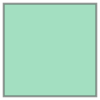

In [5]:
box = box(121.05, 14.6, 121.1, 14.65)
box

In [9]:
G_clip = clip_new(G_cleaned, box, source_crs = 'epsg:4326', 
                  target_crs = 'epsg:4326', geom_col = 'geometry')

pre_clip | nodes: 89758 | edges: 247696
post_clip | nodes: 4107 | edges: 11407


In [10]:
G_clip = keep_largest_component(G_clip)

pre_removal | nodes: 4107 | edges: 11407
post_removal | nodes: 4075 | edges: 11367


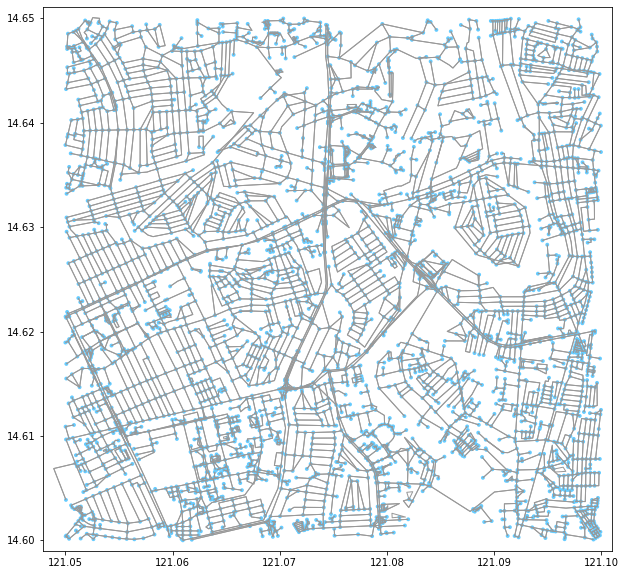

(<Figure size 734.362x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f40829805c0>)

In [13]:
G_clip.graph.update( {'crs' : crs_global} )
G_clip.graph.update( {'name' : 'manila'} )
ox.plot_graph(G_clip, fig_height=10, axis_off=False)

In [14]:
gn.save(G_clip,'manila_clean_clipped','data_osm_raw')

## convert network to time

In [1]:
from shapely.wkt import loads
from shapely.geometry import LineString
from shapely.ops import transform
import pyproj

import geopandas as gpd
import pandas as pd
import os, sys
import GOSTnets as gn
import importlib
from osgeo import ogr
import networkx as nx

In [2]:
cd /home/op/network_manila

/home/op/network_manila


In [3]:
def unbundle_wkt_geometries(G, geometry_tag = "Wkt"):
    
    """
    Function for unbundling WKT geometries. Normally, the wkt object should be a string describing the geometry
        However, sometimes it is a list of strings. 
        In such a case, this functions converts this list into an equivalent str
    :param G: a graph containing one or more nodes
    :param geometry_tag: the name of the edge attribute holdings its geometry
    :returns: a graph object with unbundled WKT geometries
    """

    G_copy = G.copy()
    
    #iterate through all edges of graph
    for u, v, data in G_copy.edges(data=True):
           
        # get geometry of node (and construct straight line if there is none)
        if geometry_tag in data:
            #if the geometry tag is Wkt we first have to load the geometry into shapely
            if geometry_tag == "Wkt":
                
                #if it isnt really WKT string but some WKT strings in a list, we first have to unbundle them
                if isinstance(data[geometry_tag], str) == False:
                    geom = gn.unbundle_geometry(data[geometry_tag])
                    
                    data[geometry_tag] = geom.wkt
        
    return G_copy

In [4]:
def calculate_edge_lengths(G, epsg_distance, epsg_source = "epsg:4326", geometry_tag = "Wkt", 
                           xCol='x', yCol = 'y',  new_length_column = "length_m"):
    
    """
    Function for calculating length of edges in the specificed CRS
    Note: this does not change the crs of the graph! the returned graph is in the same crs as the passed one
    :param G: a graph containing one or more nodes
    :param epsg_source: the crs of the input graph
    :param epsg_distance: the (usually projected) crs in which to measure the distance. format is "epsg:XYZ". 
    :param geometry_tag: the name of the edge attribute holdings its geometry, if available
    :param xCol: if no shapely geometry but Longitude present, assign here
    :param yCol: if no shapely geometry but Latitude present, assign here
    :param new_length_column: the name of the edge attribute holding the newly calculated length in the unit of epsg_distance
    :returns: a graph object 
    """

    G_copy = G.copy()
    
    #define transformer from source to crs in which we want to measure length
    project = pyproj.Transformer.from_proj(
        pyproj.Proj(init = epsg_source), # source coordinate system
        pyproj.Proj(init = epsg_distance)) # destination coordinate system

    
    #iterate through all edges of graph
    for u, v, data in G_copy.edges(data=True):
           
        # get geometry of node (and construct straight line if there is none)
        if geometry_tag in data:
            #if the geometry tag is Wkt we first have to load the geometry into shapely
            if geometry_tag == "Wkt":
                geom = loads(data[geometry_tag])
                
            #if there is a non WKT geometry attribute, we assume it is already a shapely object
            else:
                geom = data[geometry_tag]
                
        #we enter this case if the node doesn't have an attribute fitting the geometry_tag
        else:
            # if it doesn't have a geometry attribute, we assume the edge is a straight
            # line from node to node
            x1 = G.nodes[u][xCol]
            y1 = G.nodes[u][yCol]
            x2 = G.nodes[v][xCol]
            y2 = G.nodes[v][yCol]
            geom = LineString([(x1, y1), (x2, y2)])

        # project geometry into new crs
        geom_transformed = transform(project.transform, geom)  # project geometry into new crs
        
        #add length of edge into road geometry
        data[new_length_column] = geom_transformed.length
        #this length is measured in the unit of the crs!
        
    return G_copy

In [5]:
G_cleaned = nx.read_gpickle('data_osm_raw/manila_clean.pickle')

In [6]:
G_cleaned = unbundle_wkt_geometries(G_cleaned, geometry_tag = "Wkt")

In [7]:
G_cleaned = calculate_edge_lengths(G_cleaned, epsg_distance = "epsg:3123", epsg_source = "epsg:4326", 
                                   geometry_tag = "Wkt", xCol='x', yCol = 'y', new_length_column = "length_m")

In [8]:
speed_dict_manila = {
                'residential': 15,  # kmph
                'primary': 35, # kmph
                'primary_link':30,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 35,
                'trunk_link': 30,
                'secondary': 25,
                'secondary_link': 20,
                'tertiary': 25,
                'tertiary_link': 20,
                'unclassified': 15
                }

In [9]:
G_cleaned = gn.convert_network_to_time(G_cleaned, distance_tag = 'length_m', graph_type = 'drive', 
                                    road_col = 'infra_type', speed_dict = speed_dict_manila, 
                                    walk_speed = 4.5, factor = 1, default = "unclassified")

#in seconds

In [10]:
gn.example_edge(G_cleaned)

(0, 19650, {'Wkt': 'LINESTRING (121.032836 14.566063, 121.033509 14.5655514)', 'id': 18962, 'infra_type': 'residential', 'osm_id': '23006710', 'key': 'edge_18962', 'length': 91.99697752929592, 'Type': 'legitimate', 'length_m': 91.99697752929592, 'time': 22.07927460703102, 'mode': 'drive'})


In [11]:
gn.save(G_cleaned,'manila_clean','data_osm_raw')